# Variational Auto Encoder - TD Programmation Sous Contrainte

$ z = f_{\theta_1}(x) $ 

$ \hat x = g_ {\theta_2}(x)  $

$ z \approx q(z|x) -> z \approx N(\mu_\theta(x), \sigma_\theta(x).I_d)$ 

$\mathcal{L}(q) =\mathbb{E}_q\lbrack \log p(x|z) \rbrack - KL(q_{\lambda}(z)||p(z))$


Nous considérons que $z$ suis une loi normale qui prendra $\mu$ et $\sigma$ comme paramètres.

In [82]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [83]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Creating model

In [84]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )
        self.encode_mu = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.encode_sigma = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decode = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )

    def forward(self, x, train=True):
        x = self.flatten(x)
        mu_z = self.encode_mu(x)
        sigma_z = self.encode_sigma(x)
        if train :
            eps = torch.randn_like(sigma_z)
            x = self.decode(mu_z + eps * torch.exp(sigma_z))
            return x, mu_z, sigma_z

        else :
            return self.decode(mu_z), mu_z, torch.exp(sigma_z)

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
  (encode_mu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (encode_sigma): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): Re

In [85]:
loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [94]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred,mu,sigma = model(X)
        pred = pred.view(X.shape)
        KL = 0.5 * (mu**2 + sigma**2 - torch.log(sigma**2) - 1)
        loss = loss_fn(pred, X) + KL.sum() 

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred,mu,sigma = model(X)
            pred = pred.view(X.shape)
            KL = mu**2 + sigma**2 - torch.log(sigma**2) - 1

            test_loss += loss_fn(pred, X).item() + KL.sum().item()
            correct += (pred.flatten(1).argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [95]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2081.788086  [   64/60000]
loss: 2092.527588  [ 6464/60000]
loss: 2156.852295  [12864/60000]
loss: 2079.370117  [19264/60000]
loss: 2119.340820  [25664/60000]
loss: 2174.499268  [32064/60000]
loss: 1850.591553  [38464/60000]
loss: 1948.707764  [44864/60000]
loss: 2053.998535  [51264/60000]
loss: 2146.766113  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 2302.643196 

Epoch 2
-------------------------------
loss: 2062.327637  [   64/60000]
loss: 1973.395752  [ 6464/60000]
loss: 1971.570190  [12864/60000]
loss: 2049.817627  [19264/60000]
loss: 2215.357422  [25664/60000]
loss: 2113.808105  [32064/60000]
loss: 1929.680420  [38464/60000]
loss: 2002.066162  [44864/60000]
loss: 2118.055908  [51264/60000]
loss: 2031.150146  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 2303.061816 

Epoch 3
-------------------------------
loss: 2099.408691  [   64/60000]
loss: 1937.711670  [ 6464/60000]
loss: 1991.770386  [12864/60000]
loss: 1996.37

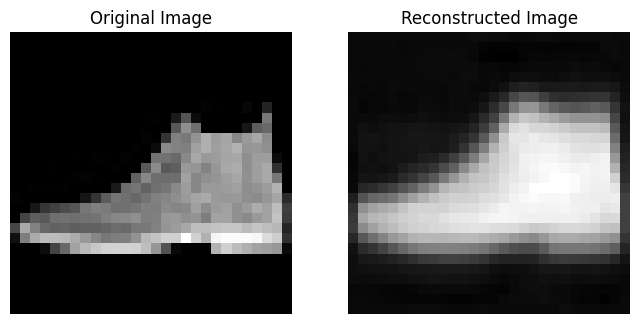

In [96]:
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
x, y = test_data[0][0], test_data[0][1] # x is the original image, y is the label (not used for display)
with torch.no_grad():
    x = x.to(device)
    # Add a batch dimension to the input
    x = x.unsqueeze(0)
    pred, mu ,sigma = model(x)
    # Reshape the output prediction back to image shape
    reconstructed_image = pred.view(x.shape)

    # Display the original and reconstructed images
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Original Image
    axes[0].imshow(x.squeeze().cpu().numpy(), cmap='gray') # Removed transpose
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Reconstructed Image
    axes[1].imshow(reconstructed_image.squeeze().cpu().numpy(), cmap='gray') # Removed transpose
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

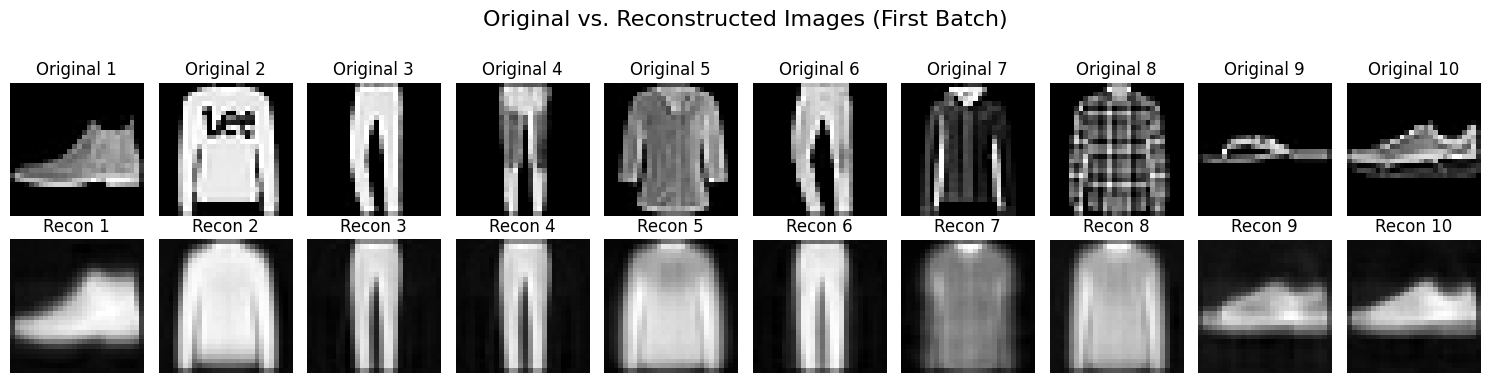

In [97]:
model.eval()
# Get one batch of test images
dataiter = iter(test_dataloader)
images, _ = next(dataiter) # We only need the images, not the labels for reconstruction
images = images.to(device)

with torch.no_grad():
    # Get reconstructed images
    reconstructed_images, mu,sigma = model(images)
    reconstructed_images = reconstructed_images.view(images.shape)

# Move images to CPU and convert to numpy for plotting
reconstructed_images = reconstructed_images.cpu().numpy()
original_images = images.cpu().numpy() # Also get original images for comparison if desired

# Plot the reconstructed images
# We'll plot a subset, e.g., the first 10 images from the batch
num_images_to_show = 10
fig, axes = plt.subplots(2, num_images_to_show, figsize=(15, 4))
plt.suptitle("Original vs. Reconstructed Images (First Batch)", fontsize=16)

for i in range(num_images_to_show):
    if i < len(original_images):
        # Original Image
        axes[0, i].imshow(original_images[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')

        # Reconstructed Image
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Recon {i+1}')
        axes[1, i].axis('off')
    else:
        # Hide unused subplots
        axes[0,i].axis('off')
        axes[1,i].axis('off')
        
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()